To do:
* want to download the data to this google colab notebook
* want to load the data in Pandas dataframe somehow
* want to create function that returns the x,y for train, test, validation

In [ ]:
# create api key folder, download fruits360 dataset (https://www.kaggle.com/moltean/fruits), unzip to fruits dir
# the only thing you need to do to run this is upload the kaggle.json to the default folder
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json
! kaggle datasets download -d moltean/fruits

# unzip the data file
import zipfile
with zipfile.ZipFile("fruits.zip", 'r') as zip_ref:
    zip_ref.extractall("fruits")

100% 1.28G/1.28G [00:33<00:00, 36.7MB/s]
100% 1.28G/1.28G [00:33<00:00, 41.3MB/s]


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import glob
import cv2
import os

np.random.seed(1234)

def get_fruit360_data(directory, types):
  X = []
  Y = []
  for t in types:
    path = os.path.join(directory, t)
    for image in os.listdir(path):
      X.append(cv2.cvtColor(cv2.imread(os.path.join(path, image), cv2.IMREAD_GRAYSCALE), cv2.COLOR_BGR2RGB)) 
      # cv2 reads in BGR, so convert to RGB
      Y.append(cv2.cvtColor(cv2.imread(os.path.join(path, image)), cv2.COLOR_BGR2RGB)) 
      # inefficient because we're reading twice but whatever
  return np.array(X) / 255, np.array(Y) / 255

X_train, Y_train = get_fruit360_data("fruits/fruits-360_dataset/fruits-360/Training/", ["Avocado", "Apple Red 1", "Apple Red 2", "Apple Red 3"])
X_test, Y_test = get_fruit360_data("fruits/fruits-360_dataset/fruits-360/Test/", ["Avocado", "Apple Red 1", "Apple Red 2", "Apple Red 3"])
print(X_train.shape, Y_train.shape)
# do we need to flatten these? probably

(1840, 100, 100, 3) (1840, 100, 100, 3)


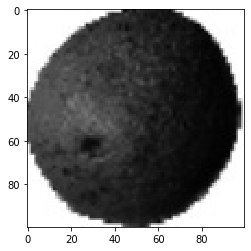

In [ ]:
plt.imshow(X_train[0], interpolation='nearest')
plt.show()

Now we want to create, train and evaluate the model on this data

In [ ]:
# create model

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization, Activation, UpSampling2D
from tensorflow.keras.callbacks import EarlyStopping, TensorBoard
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Conv2D, MaxPool2D, Flatten

model = Sequential()
model.add(Conv2D(18, 5, input_shape=(X_train.shape[1],X_train.shape[2],X_train.shape[3],), # (100, 100, 3)
                data_format="channels_last",
                activation='relu', kernel_initializer='he_normal',
                padding='same'))
model.add(Conv2D(16, 5, activation='relu', kernel_initializer='he_normal',padding='same',strides=2))
model.add(Conv2D(12, 5, activation='relu', kernel_initializer='he_normal',padding='same'))
model.add(Conv2D(9, 5, activation='relu', kernel_initializer='he_normal',padding='same',strides=2))
model.add(UpSampling2D((2, 2)))
model.add(Conv2D(32, 3, activation='relu', kernel_initializer='he_normal', padding='same'))
model.add(UpSampling2D((2, 2)))
model.add(Conv2D(3, 3, activation='tanh', kernel_initializer='he_normal', padding='same'))
model.compile(loss='mse', optimizer=Adam(learning_rate=0.001))

In [ ]:
# train model
es = EarlyStopping(monitor='val_loss', 
                   patience=5, verbose=1,
                   restore_best_weights=True)
model.fit(X_train, Y_train, epochs=2, 
          callbacks=[es],
          batch_size=16, shuffle=True,  
          validation_split=0.2)

Epoch 1/2
92/92 [==============================] - 52s 563ms/step - loss: 0.0767 - val_loss: 0.0129
Epoch 2/2
92/92 [==============================] - 54s 584ms/step - loss: 0.0097 - val_loss: 0.0084


In [ ]:
# evaluate model
model.evaluate(X_test, Y_test)

20/20 [==============================] - 5s 266ms/step - loss: 0.0077


0.007742663845419884

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


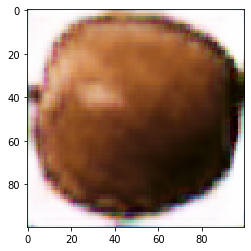

In [ ]:
plt.imshow(predict[600], interpolation='nearest')
plt.show()